# ***FILM PERFOMANCE ANALYSIS***

---





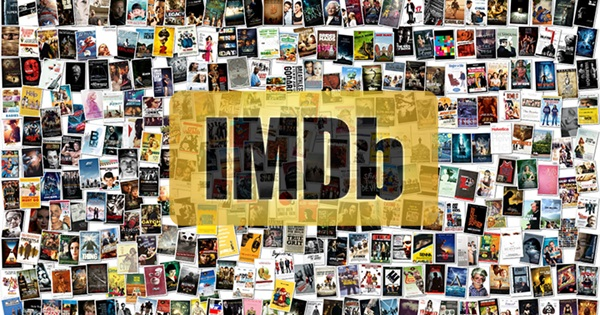

## **Overview**

---



This project aims to use exploratory data analysis(EDA) among other data anlysis tools to generate valuable market foresight in the film industry for a business stakeholder.

## ***Business Problem***

---

The company sees an opportunity in venturing into original video creation.They have decided to create a new movie studio,the current market is dominated by established studios with strong franchises, massive marketing budgets, and global distribution power.

The aim is to determinine what types of films a new studio can produce that align with current audience demand, minimize financial risk, and still allow the company to compete for box-office revenue.

## ***Data Understanding And Preparation***

---
The dataset is derived from publicly available movie databases including Box Office Mojo, IMDb, Rotten Tomatoes, and The Movie Database.These sources are widely recognized platforms that aggregate data from industry reports, critics, and user contributions, making the dataset suitable for analyzing relationships between movie characteristics, reception, and commercial success.



In [43]:
# import the relevant libraries

import pandas as pd
from scipy.stats import skew, kurtosis
import numpy as np
import _sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.stats import norm


We used three datasets to do our analysis and come up with actionable insights.



#1.bom.movies.csv

* This is a csv file that contains movies, studio, gross domestically and foreign and year of release.

In [ ]:
# Loading our dataset

df = pd.read_csv('bom.movie_gross.csv')
df.head(10) # Quick look at our data

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [ ]:
# How big is our data?
df.shape

(3387, 5)

In [ ]:
# what type of columns are we working with?
df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [ ]:
# General summary of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [ ]:
# Statistical summary for the numeric columns.
df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000




*   Mean is much higher than the median indicating a right skewed distribution caused by a few movies earning higher revenue.
*   Revenues vary widely, from very low grossing movies to extremely sucessfull.

*  Most movies in the dataset were released around 2013-2014.

* More movies earn more internationally than domestically.

* Foreign earnings vary even more widely than domestic earnings.



In [ ]:
# Check for missing values.
df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [ ]:
# Dropping the missing values
df_cleaned = df.dropna(subset=["domestic_gross", "foreign_gross"])

In [ ]:
# Converting the foreign_gross column to a numeric column
for col in ["domestic_gross", "foreign_gross"]:
    df_cleaned[col] = pd.to_numeric(
        df_cleaned[col].astype(str).str.replace(",", ""),
        errors="coerce"
    )

In [ ]:
# Feature Engineering
df_cleaned["net_gross"] = (
    df_cleaned["domestic_gross"] + df_cleaned["foreign_gross"]
)

* Looking at only domestic or only foreign gross gives a partial and sometimes misleading picture.

* Net gross gives you a movie’s total box-office performance, not just how it did in one market.



In [ ]:
# Do we have any duplicated values?
df.duplicated().sum()

np.int64(0)



*   There are no duplicated values in our dataset.



In [ ]:
# Resetting the dataframe index
df_cleaned = df.reset_index(drop=True)

In [ ]:
# Verifying changes
df_cleaned.shape
df_cleaned.info()
df_cleaned.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2009 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2009 non-null   float64
 3   foreign_gross   2009 non-null   float64
 4   year            2009 non-null   int64  
 5   net_gross       2009 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 94.3+ KB


,0
title,0
studio,2
domestic_gross,0
foreign_gross,0
year,0
net_gross,0


#2.The tmdb.csv

This file  contains info on various aspects of different movies like title, release date , ratings e.t.c

In [ ]:
tm_df = pd.read_csv('Data/tmdb.movies.csv',index_col=0)
tm_df.head(10)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229
6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340
8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057
9,"[16, 28, 35, 10751, 878]",38055,en,Megamind,22.855,2010-11-04,Megamind,6.8,3635


In [ ]:
# How big is our data?
tm_df.shape

(26517, 9)



*   Our dataset has 26,517 columns and 10 rows.


In [ ]:
# General summary of our data
tm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB




*  Our dataset has no missing values.
*  The release date column is of type object and should be converted to datetime.



# ***Data Cleaning***

---



In [ ]:
# What is the genre_id column made of

tm_df['genre_ids'].head()

0        [12, 14, 10751]
1    [14, 12, 16, 10751]
2          [12, 28, 878]
3        [16, 35, 10751]
4          [28, 878, 12]
Name: genre_ids, dtype: object



*   Genre Id which is an important column is not readable and it would be better if we can map the genre_ids to their respective genres.

In [ ]:
# strings to integers

tm_df['genre_ids'] = tm_df['genre_ids'].apply(
    lambda x: list(map(int, ast.literal_eval(x)))
)




*  genre ids are stored inside python strings we have to convert them to integers for our mapping to work.



In [ ]:
# mapping our genres
genre_map = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    18: "Drama",          # TMDB Genre mapping
    14: "Fantasy",
    27: "Horror",
    53: "Thriller",
    80: "Crime",
    878: "Science Fiction",
    10749: "Romance",
    10751: "Family"
}


In [ ]:
tm_df['genres'] = tm_df['genre_ids'].apply(
    lambda ids: [genre_map.get(i, 'Other') for i in ids]
)


In [ ]:
tm_df['genres'].head(10)

0                         [Adventure, Fantasy, Family]
1              [Fantasy, Adventure, Animation, Family]
2                 [Adventure, Action, Science Fiction]
3                          [Animation, Comedy, Family]
4                 [Action, Science Fiction, Adventure]
5                         [Adventure, Fantasy, Family]
6        [Action, Adventure, Fantasy, Science Fiction]
7                          [Animation, Family, Comedy]
8                          [Animation, Family, Comedy]
9    [Animation, Action, Comedy, Family, Science Fi...
Name: genres, dtype: object



*  Now we have a more readable column and we can associate movies to their genres.



In [ ]:
tmdf_cleaned = tm_df.explode('genres').copy()



*   Flattening a nested list column for easier analysis.




In [ ]:
# converting the release date column to type datetime
tm_df["release_date"] = pd.to_datetime(tm_df["release_date"], errors="coerce")

# Extracting Release year from the column.
tm_df["release_year"] = tm_df["release_date"].dt.year



In [ ]:
# Renaming some of the columns

tmdf_cleaned = tm_df.rename(columns={'vote_average':'AVG Rating','vote_count':'Vote Count','genres':'Genre','popularity':'Popularity'})

In [ ]:
# Dropping genre_id column

tmdf_cleaned = tmdf_cleaned.drop(columns=['genre_ids'])



*   Since we already mapped our genre ids to their genres we no longer need the latter column.




In [ ]:
# Saving the cleaned dataset
tmdf_cleaned.to_csv('tmdb.movies_cleaned.csv',index=False)

#3. im.db dataset

* This is an sql dataset that contains information about various aspects of the movie production process like actors,directors,writers e.t.c.


In [10]:
import zipfile
import os
import sqlite3

# Define the path to the zip file and extraction directory
zip_file_path = 'im.db.zip'
extract_dir = 'Data' # Extract to the same Data folder

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verify extraction (optional)
extracted_db_path = os.path.join(extract_dir, 'im.db')
print(f"Extracted database path: {extracted_db_path}")

Extracted database path: Data/im.db


In [18]:
db_path = "Data/im.db" # ← use the extracted path
conn = sqlite3.connect(db_path)

pd.read_sql("""
SELECT name
FROM sqlite_master
WHERE type = 'table';
""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [29]:
pd.read_sql("""
SELECT *
FROM movie_basics
LIMIT 50;
""",conn
)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


## ***Data Analysis And Visualization***

---





# Uni-variate analysis



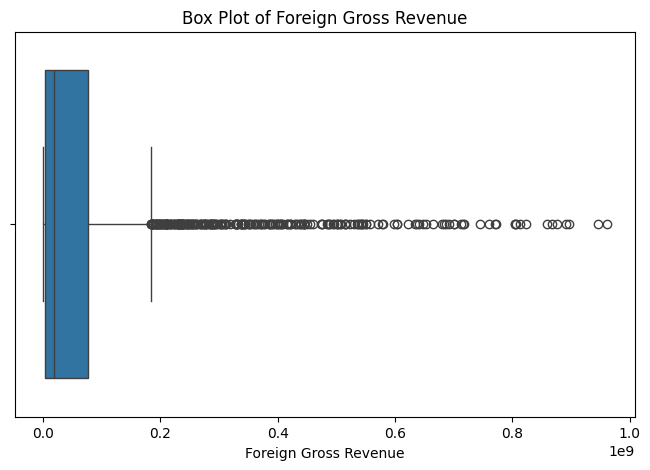

In [36]:
df = pd.read_csv('bom.movie_gross(cleaned).csv')

plt.figure(figsize=(8,5))
sns.boxplot(x=df['foreign_gross'])
plt.title("Box Plot of Foreign Gross Revenue")
plt.xlabel("Foreign Gross Revenue")
plt.show()

In [42]:
cols = ['domestic_gross','foreign_gross','net_gross']

for col in cols:
    print(col)
    print("Skew:", skew(df[col].dropna()))
    print("Kurtosis:", kurtosis(df[col].dropna()))
    print("---")


domestic_gross
Skew: 3.7091956892429345
Kurtosis: 20.329185706835336
---
foreign_gross
Skew: 3.0701974178134774
Kurtosis: 10.687705061520475
---
net_gross
Skew: 2.9994078960354407
Kurtosis: 10.357110399458993
---


<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1379168188.py:7: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].replace('[\$,]', '', regex=True)


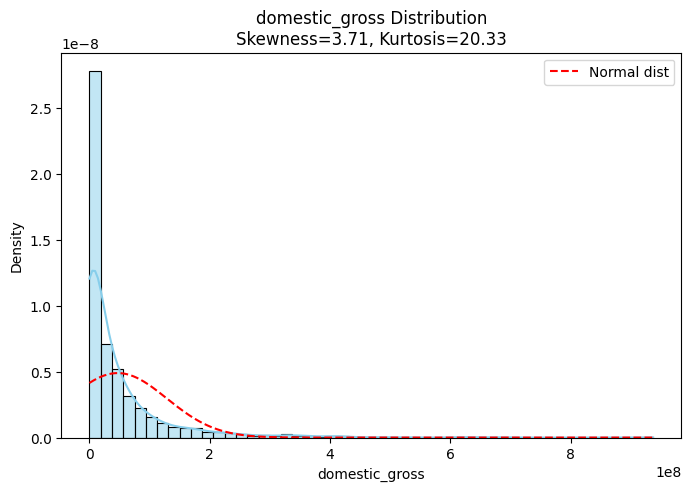

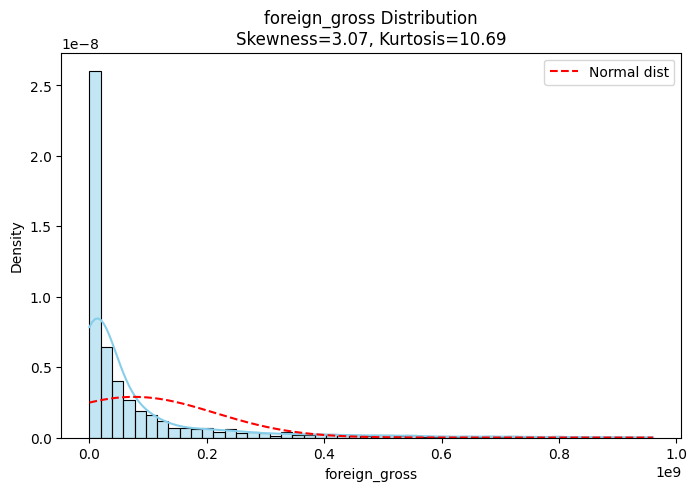

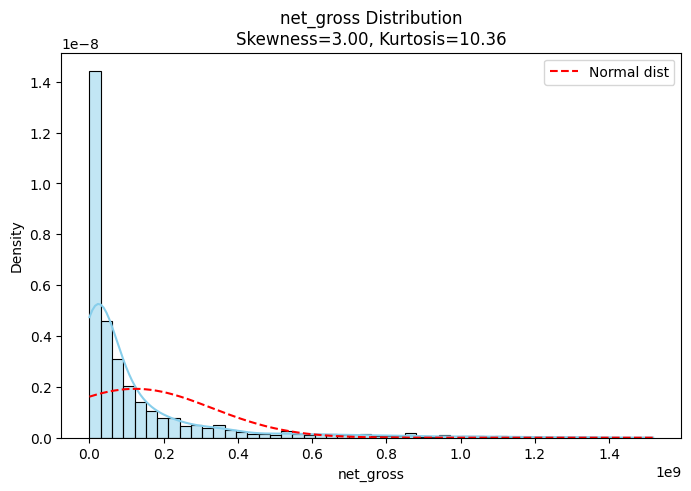

In [45]:
# Compute skew and kurtosis

cols = ['domestic_gross', 'foreign_gross', 'net_gross']

# Clean numeric columns (remove $, commas if needed)
for col in cols:
    df[col] = df[col].replace('[\$,]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df[cols].dropna()

for col in cols:
    data = df_clean[col]

    s = skew(data)
    k = kurtosis(data)

    # Plot histogram + density + normal overlay
    plt.figure(figsize=(8,5))
    sns.histplot(data, bins=50, kde=True, color='skyblue', stat='density')

    # Overlay normal distribution for comparison
    x = np.linspace(data.min(), data.max(), 1000)
    plt.plot(x, norm.pdf(x, data.mean(), data.std()), color='red', linestyle='--', label='Normal dist')

    plt.title(f'{col} Distribution\nSkewness={s:.2f}, Kurtosis={k:.2f}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [46]:
 # Frequency Table

bins = [0, 10e6, 50e6, 100e6, 500e6, 1e9]
labels = ['0-10M', '10-50M', '50-100M', '100-500M', '500M+']
df['domestic_bin'] = pd.cut(df['domestic_gross'], bins=bins, labels=labels)
df['domestic_bin'].value_counts().sort_index()

,count
domestic_bin,
0-10M,893
10-50M,549
50-100M,283
100-500M,275
500M+,9


/tmp/ipython-input-3274623323.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='viridis')


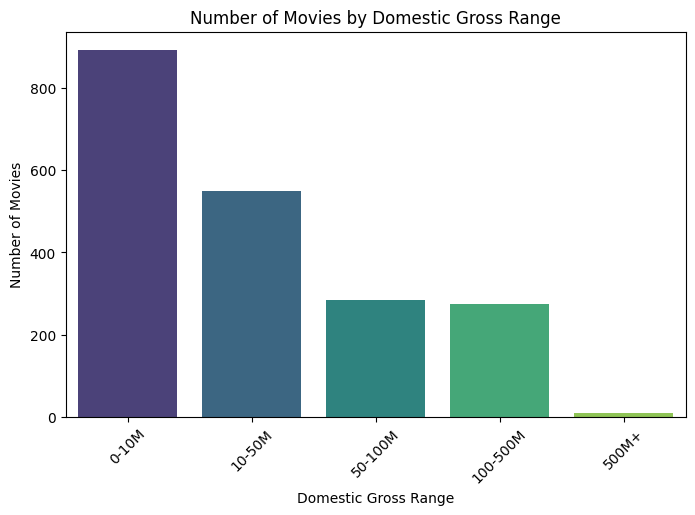

In [47]:
# Count the number of movies in each bin
bin_counts = df['domestic_bin'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='viridis')
plt.title("Number of Movies by Domestic Gross Range")
plt.xlabel("Domestic Gross Range")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()